In [ ]:
!nvidia-smi

Mon May 15 05:56:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense
from PIL import Image
from numpy import expand_dims
from keras.preprocessing.image import ImageDataGenerator

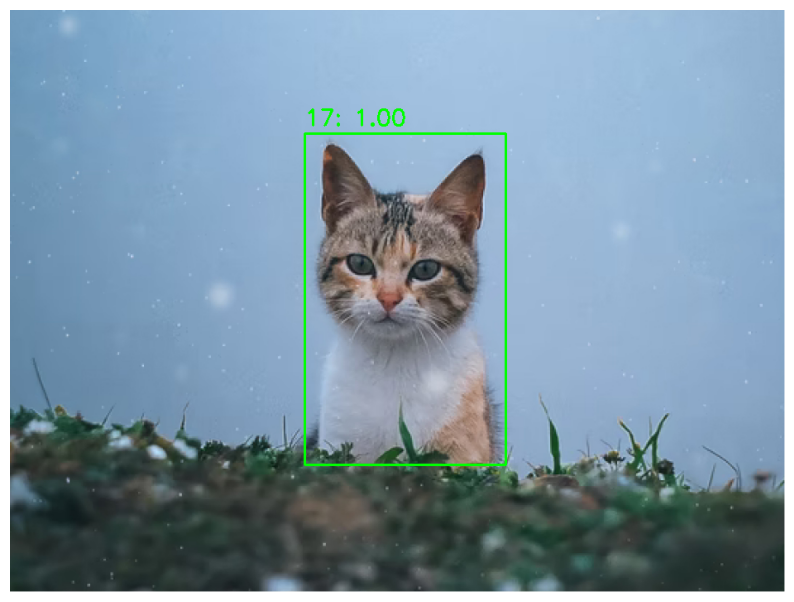

In [ ]:
import urllib.request
import cv2
import tensorflow as tf
import tensorflow_hub as hub

url = "https://huggingface.co/tasks/assets/object-detection/object-detection-input.jpg"
image_path = "/content/cat.jpg"
urllib.request.urlretrieve(url, image_path)

image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Faster R-CNN model
model = hub.load("https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1")

input_tensor = tf.convert_to_tensor(image_rgb)
input_tensor = input_tensor[tf.newaxis, ...]

detections = model(input_tensor)
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
detections['num_detections'] = num_detections

image_with_detections = image_rgb.copy()

min_confidence = 0.5

for i in range(num_detections):
    class_id = int(detections['detection_classes'][i])
    class_label = str(class_id)  # Use class ID as label for now
    confidence = detections['detection_scores'][i]

    if confidence > min_confidence:
        box = detections['detection_boxes'][i]
        ymin, xmin, ymax, xmax = box
        xmin = int(xmin * image.shape[1])
        xmax = int(xmax * image.shape[1])
        ymin = int(ymin * image.shape[0])
        ymax = int(ymax * image.shape[0])

        # Bounding box
        cv2.rectangle(image_with_detections, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.putText(image_with_detections, f'{class_label}: {confidence:.2f}', (xmin, ymin - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

plt.figure(figsize=(10, 8))
plt.imshow(image_with_detections)
plt.axis('off')
plt.show()

Now, that object is being detected, we now implement the labels for the objects.

Single object

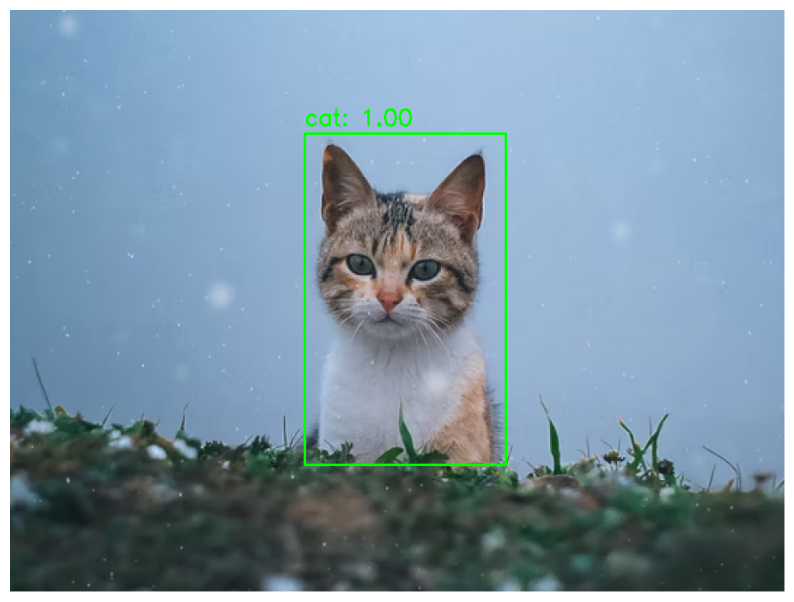

In [ ]:
# loading the image
url = "https://huggingface.co/tasks/assets/object-detection/object-detection-input.jpg"
image_path = "/content/object-detection-input.jpg"
urllib.request.urlretrieve(url, image_path)

image = Image.open(image_path)
image_rgb = np.array(image.convert("RGB"))

# Loading Faster R-CNN model from TensorFlow Hub
model = hub.load("https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1")

input_tensor = tf.convert_to_tensor(image_rgb)
input_tensor = input_tensor[tf.newaxis, ...]

detections = model(input_tensor)
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
detections['num_detections'] = num_detections

coco_labels_url = "https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt"
coco_labels_path = "/content/coco-labels.txt"
urllib.request.urlretrieve(coco_labels_url, coco_labels_path)

# Read the COCO labels file
with open(coco_labels_path, 'r') as file:
    coco_labels = file.read().splitlines()

predicted_labels = [coco_labels[int(class_id) - 1] for class_id in detections['detection_classes']]

# Printing labels of the detected objects in the image
# for label in predicted_labels:
    # print(label)

image_with_detections = image_rgb.copy()

min_confidence = 0.5

for i in range(num_detections):
    class_id = int(detections['detection_classes'][i])
    confidence = detections['detection_scores'][i]

    if confidence > min_confidence:
        class_label = coco_labels[int(class_id) - 1]
        box = detections['detection_boxes'][i]
        ymin, xmin, ymax, xmax = box
        xmin = int(xmin * image.width)
        xmax = int(xmax * image.width)
        ymin = int(ymin * image.height)
        ymax = int(ymax * image.height)

        # Bounding box
        cv2.rectangle(image_with_detections, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.putText(image_with_detections, f'{class_label}: {confidence:.2f}', (xmin, ymin - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        
plt.figure(figsize=(10, 8))
plt.imshow(image_with_detections)
plt.axis('off')
plt.show()

Multiple objects

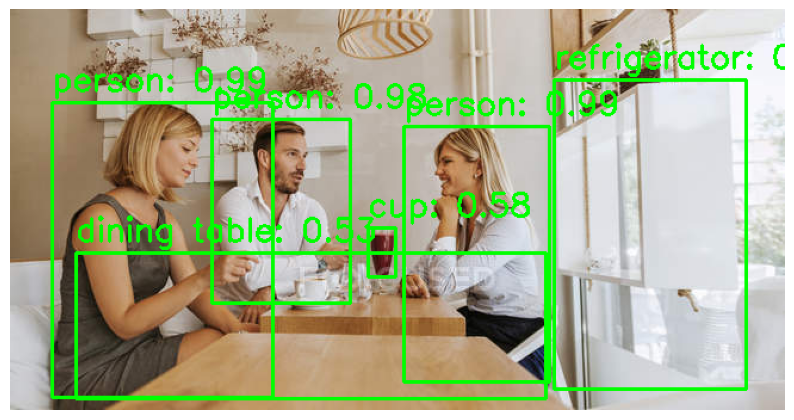

In [ ]:
# Loading image with multiple object
url = "https://st.focusedcollection.com/14026668/i/650/focused_270474880-stock-photo-three-friends-meeting-cafe.jpg"
image_path = "/content/sample.jpg"
urllib.request.urlretrieve(url, image_path)

image = Image.open(image_path)
image_rgb = np.array(image.convert("RGB"))

# Loading Faster R-CNN model from TensorFlow Hub
model = hub.load("https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1")

input_tensor = tf.convert_to_tensor(image_rgb)
input_tensor = input_tensor[tf.newaxis, ...]

detections = model(input_tensor)
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
detections['num_detections'] = num_detections

# Loading COCO labels
coco_labels_url = "https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt"
coco_labels_path = "/content/coco-labels.txt"
urllib.request.urlretrieve(coco_labels_url, coco_labels_path)

# Reading the COCO labels file
with open(coco_labels_path, 'r') as file:
    coco_labels = file.read().splitlines()
predicted_labels = [coco_labels[int(class_id) - 1] for class_id in detections['detection_classes']]

# Printing labels of the detected objects in the image

# for label in predicted_labels:
    # print(label)

image_with_detections = image_rgb.copy()

min_confidence = 0.5

for i in range(num_detections):
    class_id = int(detections['detection_classes'][i])
    confidence = detections['detection_scores'][i]

    if confidence > min_confidence:
        class_label = coco_labels[int(class_id) - 1]
        box = detections['detection_boxes'][i]
        ymin, xmin, ymax, xmax = box
        xmin = int(xmin * image.width)
        xmax = int(xmax * image.width)
        ymin = int(ymin * image.height)
        ymax = int(ymax * image.height)

        # Bounding box
        cv2.rectangle(image_with_detections, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.putText(image_with_detections, f'{class_label}: {confidence:.2f}', (xmin, ymin - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

plt.figure(figsize=(10, 8))
plt.imshow(image_with_detections)
plt.axis('off')
plt.show()